# Using Deep Learning to classify the Fashion-MNIST dataset

Neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. 

Let's start by loading the dataset through torchvision.

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. 

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`.

In [3]:
# Define your classifier
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [32]:
## Train your model with dropout, and monitor the training progress with the validation loss and accuracy
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 50
steps = 0

train_losses, test_losses, accuracies = [], [], []  # Initialise the vectors containing the losses for each epoch
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)  # forward pass
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## Implement the validation pass and print out the validation accuracy
        test_loss = 0
        accuracy = 0
        with torch.no_grad():

            # set model to evaluation mode
            model.eval()

            for images, labels in testloader:
                log_ps = model(images)  # Get the log-probabilities
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)    # Get the actual probabilities
                top_p, top_class = ps.topk(1, dim=1)   # For each of the batches, get the class that has been predicted as most probable

                # Check if the predicted classes match the labels. "top_class" and "labels" are of different shapes, so we use the view function to make them the same shape
                equals = top_class == labels.view(*top_class.shape)
                # Calculate the mean of the inferences vs. the labels in order to get the accuracy. This will be subsequently averaged out over all images in the test loader
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # set model back to train mode
        model.train()
                
        # For each of the epochs, save all the losses and accuracies in a vector (averaged over all the images in each test set)
        # These will be used for plotting later on
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracies.append(accuracy/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/50..  Training Loss: 0.610..  Test Loss: 0.499..  Test Accuracy: 0.824
Epoch: 2/50..  Training Loss: 0.480..  Test Loss: 0.435..  Test Accuracy: 0.846
Epoch: 3/50..  Training Loss: 0.445..  Test Loss: 0.427..  Test Accuracy: 0.848
Epoch: 4/50..  Training Loss: 0.434..  Test Loss: 0.421..  Test Accuracy: 0.848
Epoch: 5/50..  Training Loss: 0.424..  Test Loss: 0.395..  Test Accuracy: 0.862
Epoch: 6/50..  Training Loss: 0.414..  Test Loss: 0.411..  Test Accuracy: 0.856
Epoch: 7/50..  Training Loss: 0.401..  Test Loss: 0.409..  Test Accuracy: 0.859
Epoch: 8/50..  Training Loss: 0.397..  Test Loss: 0.398..  Test Accuracy: 0.859
Epoch: 9/50..  Training Loss: 0.393..  Test Loss: 0.381..  Test Accuracy: 0.864
Epoch: 10/50..  Training Loss: 0.389..  Test Loss: 0.388..  Test Accuracy: 0.862
Epoch: 11/50..  Training Loss: 0.384..  Test Loss: 0.400..  Test Accuracy: 0.862
Epoch: 12/50..  Training Loss: 0.376..  Test Loss: 0.401..  Test Accuracy: 0.861
Epoch: 13/50..  Training Loss: 0.373.

We can visualise the evolution of the losses and the accuracy. The testing loss is not as insightful because it is calculated while some input cells have been dropped out, hence is not 100% representative of the training performance.

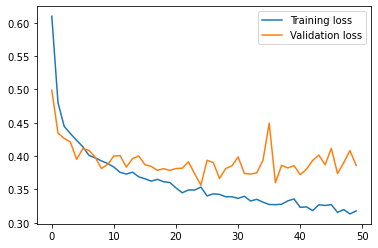

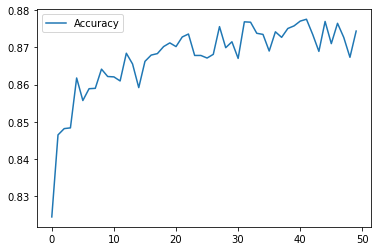

In [33]:
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

plt.figure()
plt.plot(accuracies, label='Accuracy')
plt.legend()

It is also interesting to see that the training loss does not diverge too much from the training loss.

Now, the model is trained and we can use it to make predictions on the test set.